In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("dark_background")

In [2]:
df = pd.read_pickle("tests/quality_test_results.pickle")
df["gender_fix"] = False

df_gender = pd.read_pickle("tests/quality_test_results_with_gender_fix.pickle")
df_gender["gender_fix"] = True

df_human = df[df["translator"] == "human_target"].copy()
df_human["gender_fix"] = None

df = pd.concat([
    df_human, 
    df[df["translator"] != "human_target"], 
    df_gender[df_gender["translator"] != "human_target"]
], ignore_index=True)

df = df.sort_values(["sample_idx", "translator"]).reset_index(drop=True)

df['model_details'] = (
    df["translator"] + "_" +
    np.where(df["gender_fix"], "genderfix", "genderdefault") + "_" +
    np.where(df["use_find_replace"], "preferential", "unreplaced")
)
df.loc[df['translator'] == "human_target", "model_details"] = "human_target"

In [3]:
percentiles = [0.02275, 0.1587, 0.8413, 0.97725]
rows = ['2.3%', '15.9%', '50%', '84.1%', '97.7%']
columns = ["similarity_vs_source"]

df_eval = pd.concat([
    df[columns].describe(percentiles).loc[rows].round(3).rename(columns={'similarity_vs_source': 'all_models_and_configs'}),
    df.groupby("model_details")["similarity_vs_source"].describe(percentiles=percentiles).loc[:, rows].T.round(3)
], axis=1).T.rename_axis("model_configuration").sort_index()

In [4]:
df['is_finetuned'] = df['translator'].str.contains('finetuned')
df['model'] = df['translator'].str.replace('_base', '').str.replace('_finetuned', '')

base_rows = df_eval.loc[['all_models_and_configs', 'human_target']]

def make_breakdown(groupby_col, label_map=None):
    grouped = df[df['translator'] != 'human_target'].groupby(groupby_col)['similarity_vs_source']
    result = grouped.describe(percentiles=percentiles).loc[:, rows].T.round(3).T
    if label_map:
        result.index = result.index.map(label_map)
    return pd.concat([base_rows, result]).rename_axis("model_configuration")

df_eval_finetuned = make_breakdown('is_finetuned', {False: 'base', True: 'finetuned'})
df_eval_gender = make_breakdown('gender_fix', {False: 'genderdefault', True: 'genderfix'})
df_eval_replace = make_breakdown('use_find_replace', {False: 'unreplaced', True: 'preferential'})
df_eval_model = make_breakdown('model')

In [5]:
def plot_heatmap(dataframe, figsize=(4, 6), title="Similarity vs Source Text", **kwargs):
    plt.figure(figsize=figsize)

    ax = sns.heatmap(dataframe, **kwargs)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right")

    plt.ylabel("Percentile")
    plt.title(title)

    plt.show()


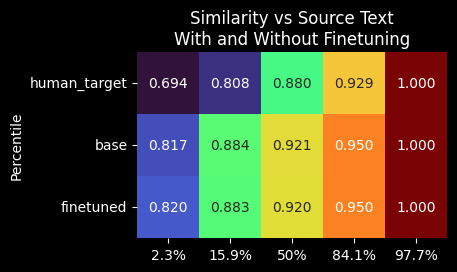

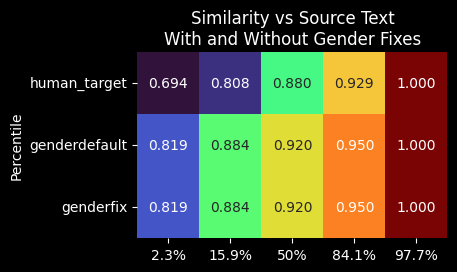

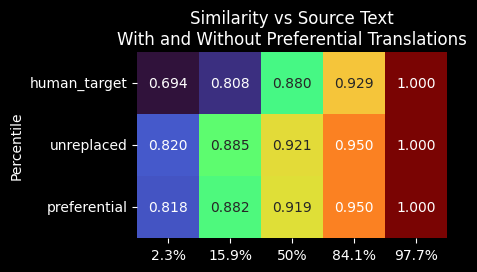

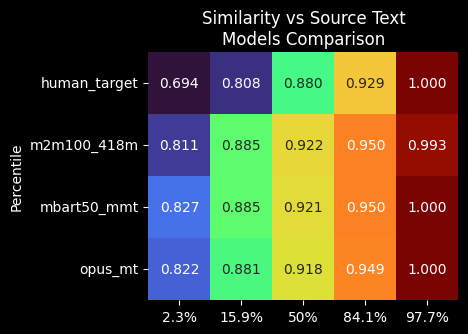

In [6]:
dataframes = [
    ("Similarity vs Source Text\nWith and Without Finetuning", df_eval_finetuned),
    ("Similarity vs Source Text\nWith and Without Gender Fixes", df_eval_gender),
    ("Similarity vs Source Text\nWith and Without Preferential Translations", df_eval_replace),
    ("Similarity vs Source Text\nModels Comparison", df_eval_model),
]

for title, df in dataframes:
    plot_heatmap(df.drop('all_models_and_configs'), title=title, cmap="turbo", annot=True, square=True, cbar=False, fmt=".3f", vmin=0.8, vmax=1.0)